# Ridge regression

![Alt text](Screenshot%202023-01-17%20133737.png)

In the last unit, we learned about 
L
2
 regularization and saw that it adds a constraint on the length of the vector of parameters.
. So far, we didn’t specify any particular model or cost function, but if we use multi-linear regressions and minimize the squares of the residuals, we obtain the ridge regression model.
<!-- 
![Alt text](Screenshot%202023-01-17%20143735.png) -->

In this unit, we will implement ridge regressions with Scikit-learn and test our model on a set of 50 noisy observations of a sine curve.

Sine curve data set
---
Let’s start by loading the training data set.

In [1]:
import pandas as pd

# Load the training data
training_data = pd.read_csv("c3_data-points.csv")

# Print shape
print("Shape:", training_data.shape)

Shape: (50, 2)


In [2]:
# First five rows
training_data.head()

,x,y
0,0.000,0.706
1,0.128,0.288
2,0.256,0.645
3,0.385,1.272
4,0.513,1.238


We generated the 50 x/y data points using a sine curve. The idea is to create 50 points on the curve and add a small noise to each point. Let’s create the x, y variables and plot the data. Note that in this unit we work only with the training set and for simplicity we use the names ``x, y`` instead of ``x_tr, y_tr``.

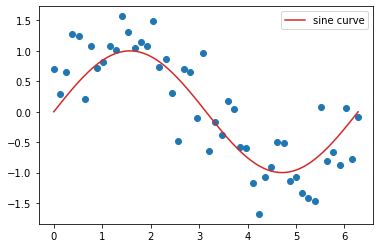

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Extract x, y data
x = training_data.x.values
y = training_data.y.values

# Plot data points
plt.scatter(x, y)

# Plot the sine curve for reference
x_values = np.linspace(min(x), max(x), num=100)
y_sine = np.sin(x_values)
plt.plot(x_values, y_sine, c="C3", label="sine curve")
plt.legend()
plt.show()

In this unit, we will try to recover this sine curve from the 50 noisy observations of it.

#### Polynomial regression

Let’s fit a polynomial regression of degree 10 to this set of points. We can generate the polynomial features using the PolynomialFeatures object from Scikit-learn.

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial feature
poly_obj = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_obj.fit_transform(x[:, np.newaxis])

print("Shape:", X_poly.shape)
print("Features:", poly_obj.get_feature_names_out())

Shape: (50, 10)
Features: ['x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5' 'x0^6' 'x0^7' 'x0^8' 'x0^9' 'x0^10']


> When include_bias is set to True, it adds a column of ones to the input array, which can be used as a bias term in the model. It will be the coefficient of the first term of the polynomial (i.e. x^0).

Later in this unit, we will apply regularization to our models. Since regularization is sensitive to the scale of our features, we will start by standardizing our data.

This is a common operation in machine learning, so Scikit-learn implements a ``StandardScaler()`` object to do it. Let’s see how to use to it.

> Standardization is a method to transform variables with different scales into a common scale (usually between 0 and 1) so that the data can be handled more easily. It is commonly used for feature scaling before applying machine learning algorithms.


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_poly)

__In this code, we first have to create the object and then call its ``fit_transform()`` function to compute the mean/standard deviation of each feature (fit) and apply standardization (transform).__

> **Note:**
Important note: The scaler object has also a transform() function which does not compute the mean/standard deviation of a feature but only applies the transformation. However, since here we are working with the training data we should use fit_transform() function. Later in this course we will see that in order to only apply the standardization on the validation and testing data we should use the transform() function. This is because we shouldn’t learn the mean/standard deviation from the validation and testing data.

Let’s verify that the data is standardized. The mean should be close to zero.

In [6]:
X_rescaled.mean(axis=0)

array([ 1.77635684e-16,  2.66453526e-16, -1.68753900e-16, -8.88178420e-18,
       -7.99360578e-17,  8.88178420e-18, -1.77635684e-17, -1.77635684e-17,
        4.44089210e-17,  1.06581410e-16])

And the standard deviation close to one.

In [7]:
X_rescaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Let’s now fit a linear regression to the standardize data and plot its prediction curve.

In [8]:
from sklearn.linear_model import LinearRegression

# Linear reggression
lr = LinearRegression()
lr.fit(X_rescaled, y)

# Pass sample x values through the preprocessing steps
X_values_rescaled = scaler.transform(poly_obj.transform(x_values[:, np.newaxis]))
y_values_lr = lr.predict(X_values_rescaled)

Note that we need to apply all the preprocessing steps to the hundred ``x_values`` used to plot the prediction curve: we first create the polynomial basis with ``poly_obj.transform()`` and then standardize the features with ``scaler.transform()`` to get the ``X_values_rescaled``. We can then pass the results to our model to get the predictions ``y_values_lr``.

Here is the result.

In [9]:
X_values_rescaled.shape

(100, 10)

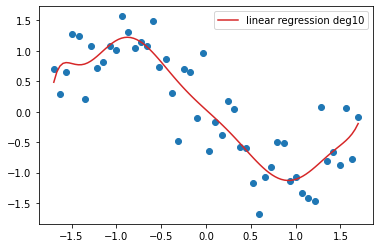

In [10]:
# Plot the model
plt.scatter(X_rescaled[:, 0], y)
plt.plot(X_values_rescaled[:, 0], y_values_lr, c="C3", label="linear regression deg10")
plt.legend()
plt.show()

As we can see, the model is clearly overfitting. Let’s try to reduce overfitting with regularization

## Ridge regression
Scikit-learn implements ridge regressions with its Ridge object from the linear_model module. This object is an estimator which means that it implements the usual ``fit(), predict()`` and ``score()`` functions.



In [11]:
from sklearn.linear_model import Ridge
# Ridge regression
ridge = Ridge()
ridge.fit(X_rescaled, y)

# Compute pretictions
y_values_ridge = ridge.predict(X_values_rescaled)

In this code, we replaced the LinearRegression object with a Ridge one. The rest of the code is the same. We get the following curve.

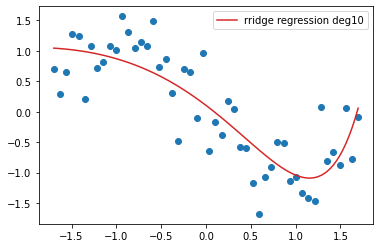

In [12]:
# Plot the model
plt.scatter(X_rescaled[:, 0], y)
plt.plot(X_values_rescaled[:, 0], y_values_ridge, c="C3", label="rridge regression deg10")
plt.legend()
plt.show()

By default, the Ridge object sets the regularization strength 
$α$
 to one. In our case, the curve is too rigid to model the data points, and the model is __underfitting__.

We can decrease the constraint on the coefficients by setting a lower alpha value.

In [13]:
# Ridge regression
ridge2 = Ridge(alpha=1e-4)
ridge2.fit(X_rescaled, y)

# Compute pretictions
y_values_ridge2 = ridge2.predict(X_values_rescaled)

In this code, we set alpha to 
$10^{-4}$
 (1e-4 in e-notation). We will see how to tune the regularization strength and compute this alpha value in the next unit.

We get the following curve.

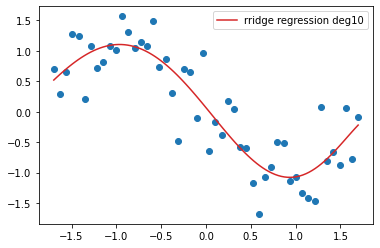

In [14]:
# Plot the model
plt.scatter(X_rescaled[:, 0], y)
plt.plot(X_values_rescaled[:, 0], y_values_ridge2, c="C3", label="rridge regression deg10")
plt.legend()
plt.show()

We can also compare the coefficients before and after adding the regularization term using the ``coef_`` attribute.

In [15]:
# Linear regression coefficients
features = poly_obj.get_feature_names_out()

for features, coef

SyntaxError: invalid syntax (3280250661.py, line 4)